In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from xgboost import XGBRegressor
import math
import plotly.graph_objs as go
import chart_studio.plotly as py
from collections import defaultdict
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
def get_mae(a, b):
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

# 601668

## 1. Load Data

In [3]:
hkws_path = 'D:/DeskTop-Files/CUHK-SZ/2022-2023 Fall term/1-Wed-14~17-IBA6 Fintech and Application/Group_final/data_new5_withdiff_withlag/data_new5_withdiff_withlag/601668_stable.xlsx'
df = pd.DataFrame(pd.read_excel(hkws_path)) 
df.head()

,日期,收益率,ret_lag1,ret_lag2,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,前收盘价(元)_diff1,...,宏观_PPI_diff1,宏观_出口价格指数(总),宏观_出口价格指数(车船航),宏观_进口价格指数(总)_diff1,宏观_进口价格指数(车船航),宏观_固定资产投资完成额,宏观_社会消费品零售总额_diff1,宏观_M2_diff2,宏观_金融机构各项贷款余额_diff1,宏观_社会融资规模_diff1
0,2016-01-22,-0.007326,0.020561,-0.032550,-0.034904,0.075047,-0.009294,-0.047788,0.010733,-1.698526,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
1,2016-01-25,-0.060886,-0.007326,0.020561,-0.032550,-0.034904,0.075047,-0.009294,-0.047788,1.041190,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
2,2016-01-26,0.005894,-0.060886,-0.007326,0.020561,-0.032550,-0.034904,0.075047,-0.009294,-0.375904,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
3,2016-01-27,-0.031250,0.005894,-0.060886,-0.007326,0.020561,-0.032550,-0.034904,0.075047,-2.322047,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098
4,2016-01-28,0.034274,-0.031250,0.005894,-0.060886,-0.007326,0.020561,-0.032550,-0.034904,0.285406,...,-0.051989,-2.162753,-0.746224,-0.028079,-0.53487,-0.820241,-0.149665,0.0,0.031278,0.018098


In [4]:
index_val = df[df.日期 == '2021-01-04'].index[0]
index_test = df[df.日期 == '2022-01-04'].index[0]
print(index_val,index_test)

1204 1447


In [5]:
df.dropna(inplace=True)
df = df.drop(['日期'], axis=1)
y = df['收益率']
X = df.drop('收益率', axis=1) 

## 2. Split train set，validation set and test set 

In [6]:
X_train = X[0:index_val].copy()
X_val = X[index_val:index_test].copy()
X_test = X[index_test:].copy()
y_train = y[0:index_val].copy()
y_val = y[index_val:index_test].copy()
y_test = y[index_test:].copy()
print("X_train.shape = " + str(X_train.shape))
print("X_val.shape = " + str(X_val.shape))
print("X_test.shape = " + str(X_test.shape))

X_train.shape = (1204, 71)
X_val.shape = (243, 71)
X_test.shape = (222, 71)


## 3. Model cinstruction_XGBOOST

In [7]:
def xgb_model_train_val(X_train, y_train, X_val, y_val,
                          seed=100, n_estimators=100, max_depth=3, learning_rate=0.1,
                          min_child_weight=1, subsample=1, colsample_bytree=1, colsample_bylevel=1, gamma=0):

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=seed, n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mae, model

In [8]:
def model_test_eval(X_test, y_test, model):
    
    # Get predicted labels
    est = model.predict(X_test)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mae, est

### 1) Prediction before tuning on validation set

In [9]:
# Get error metrics on validation set before hyperparameter tuning
xgb_rmse_bef_tuning, xgb_mae_bef_tuning,xgb_model_bef_tuning = xgb_model_train_val(X_train, y_train, X_val, y_val)
                                                                
print("RMSE = %0.3f" % xgb_rmse_bef_tuning)
print("MAE = %0.3f" % xgb_mae_bef_tuning)

RMSE = 0.013
MAE = 0.010


### 2) Tuning parameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [27]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = range(40, 60, 2)

param2_label = 'max_depth'
param2_list = [4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,
                                                            seed = 100,n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-27-52915cb55d87>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.33


,n_estimators,max_depth,rmse,mae
0,40,4,0.015057,0.012007
1,40,5,0.015103,0.011877
2,40,6,0.015079,0.011888
3,40,7,0.014979,0.011812
4,40,8,0.015052,0.011922
5,40,9,0.015331,0.012091
6,42,4,0.014401,0.011280
7,42,5,0.014487,0.011161
8,42,6,0.014453,0.011209
9,42,7,0.014324,0.011108


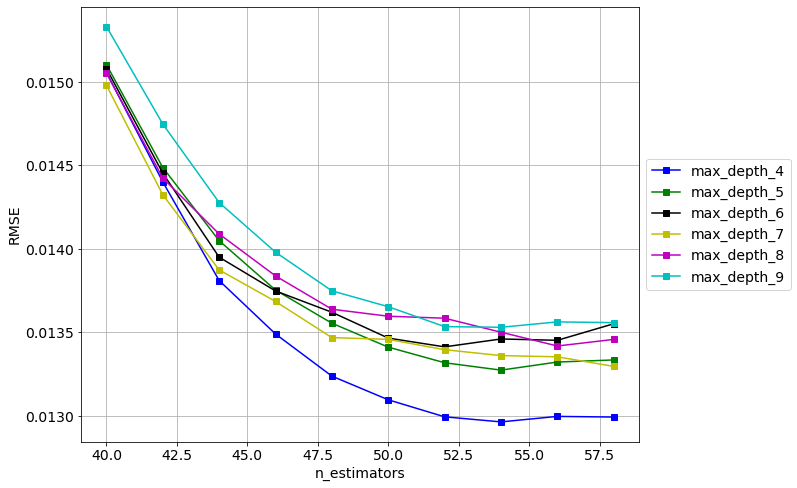

In [28]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [29]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.013
optimum params = 


(54, 4)

#### Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [30]:
param_label = 'learning_rate'
param_list = [ 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(1, 10, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-30-6dd8cafe6c94>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 0.23


,learning_rate,min_child_weight,rmse,mae
0,0.01,1,0.290865,0.290579
1,0.01,2,0.290865,0.290579
2,0.01,3,0.290865,0.290579
3,0.01,4,0.290865,0.290579
4,0.01,5,0.290865,0.290579
5,0.01,6,0.290865,0.290579
6,0.01,7,0.290865,0.290579
7,0.01,8,0.290865,0.290579
8,0.01,9,0.290865,0.290579
9,0.05,1,0.033866,0.031880


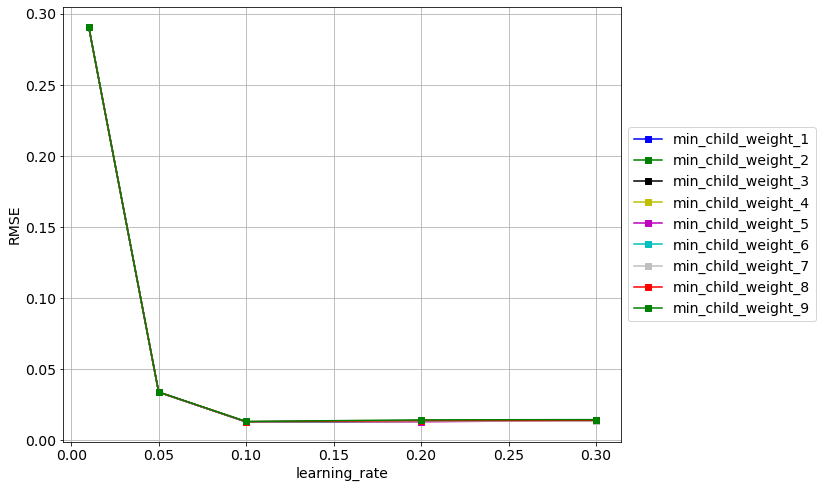

In [31]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [32]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.013
optimum params = 


(0.1, 1)

#### Tuning subsample(default=1) and gamma(default=0)

In [33]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean,  mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-33-d9f5d0e5dbc7>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.55


,subsample,gamma,rmse,mae
0,0.1,0.0,0.014779,0.011540
1,0.1,0.1,0.013005,0.009772
2,0.1,0.2,0.013005,0.009772
3,0.1,0.3,0.013005,0.009772
4,0.1,0.4,0.013005,0.009772
...,...,...,...,...
105,1.0,0.6,0.013008,0.009776
106,1.0,0.7,0.013008,0.009776
107,1.0,0.8,0.013008,0.009776
108,1.0,0.9,0.013008,0.009776


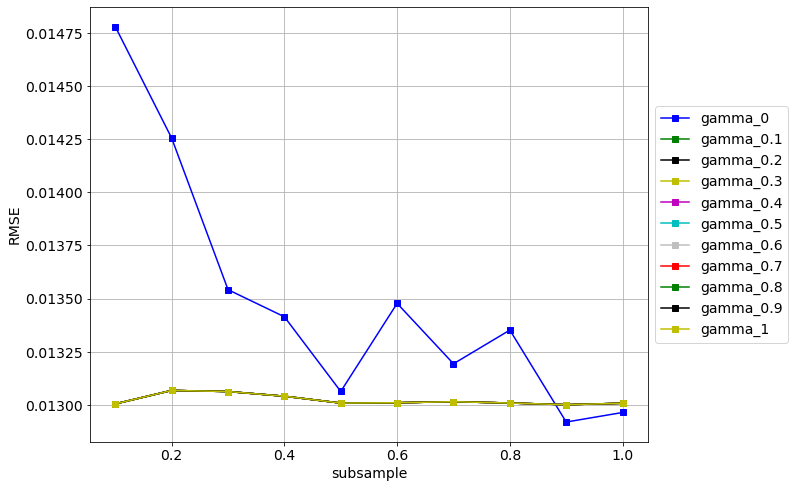

In [34]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [35]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.013
optimum params = 


(0.9, 0.0)

#### Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [36]:
param_label = 'colsample_bytree'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mae_mean,m = xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-36-4e70ea290268>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.43


,colsample_bytree,colsample_bylevel,rmse,mae
0,0.1,0.1,0.013168,0.009950
1,0.1,0.2,0.013168,0.009950
2,0.1,0.3,0.013205,0.009869
3,0.1,0.4,0.013205,0.009869
4,0.1,0.5,0.012988,0.009744
...,...,...,...,...
95,1.0,0.6,0.013260,0.009844
96,1.0,0.7,0.012983,0.009679
97,1.0,0.8,0.013154,0.009681
98,1.0,0.9,0.013141,0.009748


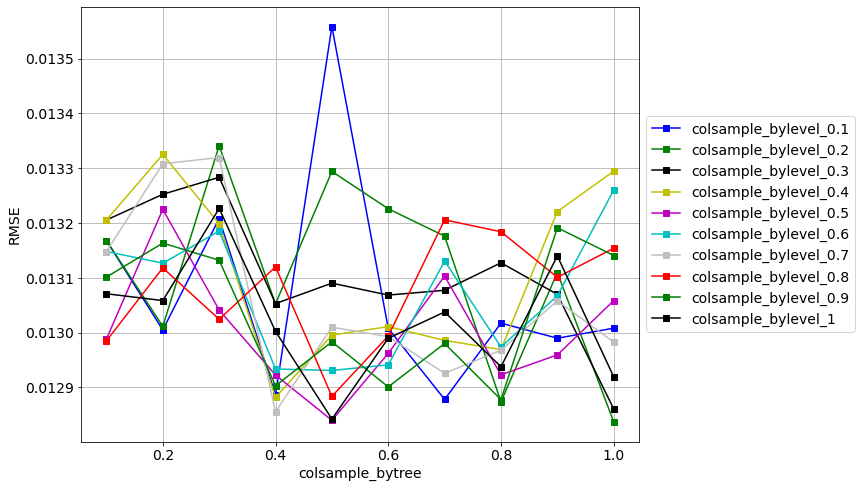

In [37]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [38]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.013
optimum params = 


(1.0, 0.2)

#### Final model

In [40]:
# Get error metrics on validation set after hyperparameter tuning
xgb_rmse_aft_tuning, xgb_mae_aft_tuning, xgb_model_aft_tuning = \
                                                                        xgb_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % xgb_rmse_aft_tuning)
print("MAE = %0.3f" % xgb_mae_aft_tuning)

RMSE = 0.013
MAE = 0.009


#### Tuned params

In [41]:
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0 

In [42]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, xgb_rmse_bef_tuning, xgb_mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, xgb_rmse_aft_tuning, xgb_mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,54.000
1,max_depth,3.000,4.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,1.000
4,subsample,1.000,0.900
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,0.200
7,gamma,0.000,0.000
8,val_rmse,0.013,0.013
9,val_mae,0.010,0.009


### 3) Prediction after tuning

In [44]:
# Do prediction on test set
xgb_test_rmse_aft_tuning, xgb_test_mae_aft_tuning,xgb_pred = model_test_eval(X_test, y_test,xgb_model_aft_tuning)

print("RMSE = %0.3f" % xgb_test_rmse_aft_tuning)
print("MAE = %0.3f" % xgb_test_mae_aft_tuning)

RMSE = 0.022
MAE = 0.017


In [45]:
# xgb_pred = pd.DataFrame(xgb_pred,columns = ['601668_xgb'])
# xgb_pred.to_excel('D:\海康威视1.xlsx', index = False)

### 4) Importance Analysis

In [47]:
a =xgb_model_aft_tuning.feature_importances_
a1 = pd.DataFrame(a)
a1.columns = ['importance']
b = X_train.columns
b1 = pd.DataFrame(b)
b1.columns = ['features']
c = pd.concat([b1,a1],axis = 1)
c.sort_values(by= 'importance' , inplace=True, ascending=False) 
c

,features,importance
63,宏观_出口价格指数(车船航),0.041225
14,涨跌(元),0.035055
1,ret_lag2,0.029748
36,WindA_周均价_diff1,0.027545
51,Industry_周均价_diff1,0.027512
...,...,...
61,宏观_PPI_diff1,0.000000
67,宏观_社会消费品零售总额_diff1,0.000000
68,宏观_M2_diff2,0.000000
59,Industry_一致预测净利润(FY2)_diff1,0.000000


                  features  importance
63          宏观_出口价格指数(车船航)    0.041225
14                   涨跌(元)    0.035055
1                 ret_lag2    0.029748
36         WindA_周均价_diff1    0.027545
51      Industry_周均价_diff1    0.027512
0                 ret_lag1    0.026065
27           周最高价(元)_diff1    0.025462
49     Industry_周最高价_diff1    0.024748
42  WindA_股息率(近12个月)_diff1    0.023809
41   WindA_市净率PB(LF)_diff1    0.022864


<AxesSubplot:ylabel='features'>

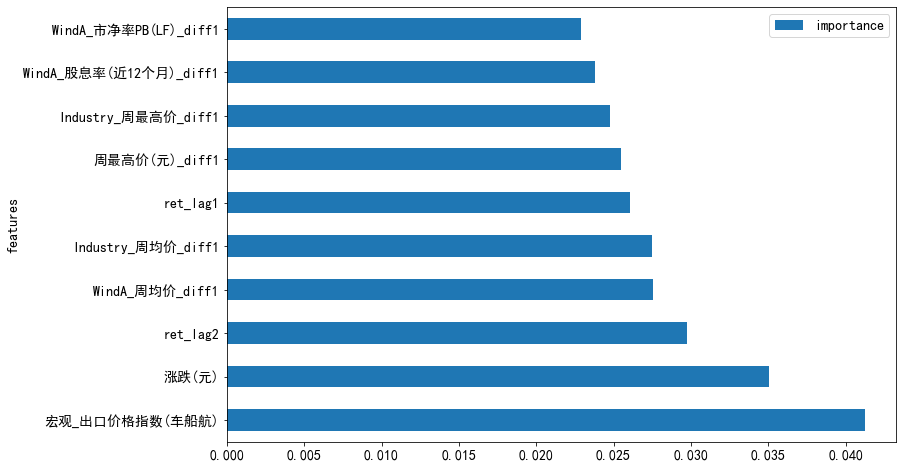

In [48]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
# 为了坐标轴负号正常显示。matplotlib默认不支持中文，设置中文字体后，负号会显示异常。需要手动将坐标轴负号设为False才能正常显示负号。
matplotlib.rcParams['axes.unicode_minus'] = False

hkws_top10 = c.head(10)
print(hkws_top10)
imp = pd.DataFrame(np.array(hkws_top10['importance']), index=hkws_top10['features'], columns=['importance'])
imp.plot(kind='barh', figsize=(12, 8))
#hkws_top10.sort_values('importance').plot(kind='barh', figsize=(12, 8))

## 4. Model construction_Random Forest

In [51]:
def rf_model_train_val(X_train, y_train, X_val, y_val,
                          n_estimators=100, 
                          max_depth=3, 
                          min_samples_split=2,
                          min_samples_leaf=1):

    model = RandomForestRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                          min_samples_split=min_samples_split,
                          min_samples_leaf=min_samples_leaf)
        
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels
    est = model.predict(X_val)

    # Calculate RMSE,MAE
    rmse = get_rmse(y_val, est)
    mae = get_mae(y_val, est)
    
    return rmse, mae, model

### 1) Tuning aprameters

#### Tuning n_estimators (default=100) and max_depth (default=3)

In [52]:
from tqdm import tqdm_notebook
param_label = 'n_estimators'
param_list = range(40, 60, 2)

param2_label = 'max_depth'
param2_list = range(45,49,1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                            n_estimators=param,max_depth=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-52-ff65d49f03b2>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 1.58


,n_estimators,max_depth,rmse,mae
0,40,45,0.013320,0.009896
1,40,46,0.013282,0.009800
2,40,47,0.012946,0.009406
3,40,48,0.013330,0.009859
4,42,45,0.013093,0.009782
5,42,46,0.012761,0.009387
6,42,47,0.012659,0.009203
7,42,48,0.013290,0.009715
8,44,45,0.013104,0.009471
9,44,46,0.013050,0.009767


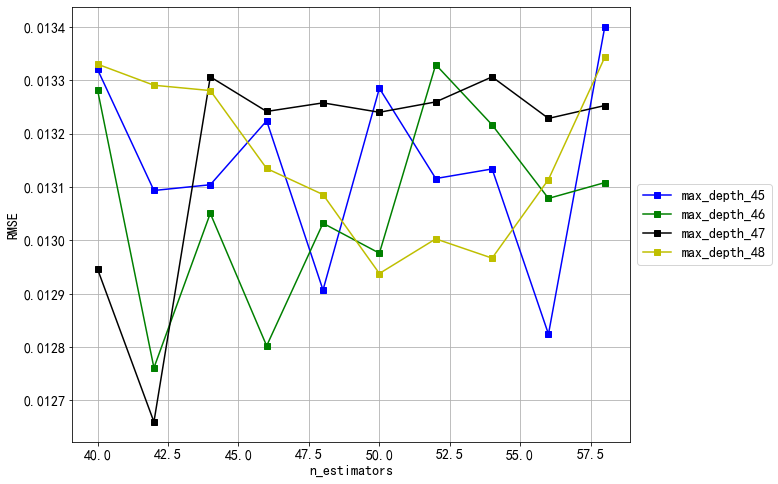

In [53]:
# Plot performance versus params
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [54]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.013
optimum params = 


(42, 47)

#### Tuning min_samples_split(default=2) and  min_samples_leaf(default=1)

In [55]:
from tqdm import tqdm_notebook
param_label = 'min_samples_split'
param_list = range(2, 5)

param2_label = 'min_samples_leaf'
param2_list = range(5,12)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mae_mean,m = rf_model_train_val(X_train, y_train, X_val, y_val,
                                                                    n_estimators=n_estimators_opt,
                                                                     max_depth=max_depth_opt,
                                                                    min_samples_split=param,
                                                                    min_samples_leaf=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-55-7cf10e88798f>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/3 [00:00<?, ?it/s]

Minutes taken = 0.44


,min_samples_split,min_samples_leaf,rmse,mae
0,2,5,0.013047,0.009552
1,2,6,0.012835,0.009310
2,2,7,0.013046,0.009496
3,2,8,0.012793,0.009452
4,2,9,0.012886,0.009456
5,2,10,0.012810,0.009333
6,2,11,0.012859,0.009352
7,3,5,0.013099,0.009474
8,3,6,0.013246,0.009695
9,3,7,0.013120,0.009635


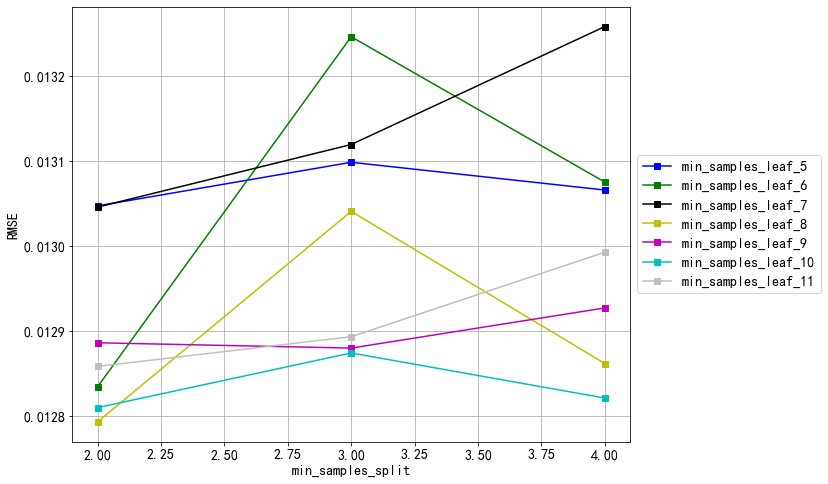

In [56]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [57]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
min_samples_split_opt = temp['min_samples_split'].values[0]
min_samples_leaf_opt = temp['min_samples_leaf'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
min_samples_split_opt, min_samples_leaf_opt

min RMSE = 0.013
optimum params = 


(2, 8)

#### Final Model

In [58]:
# Get error metrics on validation set after hyperparameter tuning
rf_rmse_aft_tuning,rf_mae_aft_tuning, rf_model_aft_tuning = \
                                                                        rf_model_train_val(X_train, y_train, X_val, y_val,                                                        
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,                                                                        
                                                                        min_samples_split=min_samples_split_opt,
                                                                        min_samples_leaf=min_samples_leaf_opt)
print("RMSE = %0.3f" % rf_rmse_aft_tuning)
print("MAE = %0.3f" % rf_mae_aft_tuning)

RMSE = 0.013
MAE = 0.009


In [59]:
# Do prediction on test set
rf_test_rmse_aft_tuning, rf_test_mae_aft_tuning,rf_pred = model_test_eval(X_test, y_test,rf_model_aft_tuning)

print("RMSE = %0.3f" % rf_test_rmse_aft_tuning)
print("MAE = %0.3f" % rf_test_mae_aft_tuning)

RMSE = 0.022
MAE = 0.017


### Importance Analysis

In [60]:
a =rf_model_aft_tuning.feature_importances_
a1 = pd.DataFrame(a)
a1.columns = ['importance']
b = X_train.columns
b1 = pd.DataFrame(b)
b1.columns = ['features']
c = pd.concat([b1,a1],axis = 1)
c.sort_values(by= 'importance' , inplace=True, ascending=True) 
c

,features,importance
25,一致预测净利润FY2(元)_diff1,0.000296
67,宏观_社会消费品零售总额_diff1,0.001356
24,一致预测净利润FY1(元)_diff1,0.001794
61,宏观_PPI_diff1,0.002062
11,收盘价(元)_diff1,0.002071
...,...,...
8,开盘价(元)_diff1,0.034390
5,ret_lag6,0.045044
3,ret_lag4,0.046338
2,ret_lag3,0.050231


               features  importance
25  一致预测净利润FY2(元)_diff1    0.000296
67   宏观_社会消费品零售总额_diff1    0.001356
24  一致预测净利润FY1(元)_diff1    0.001794
61         宏观_PPI_diff1    0.002062
11         收盘价(元)_diff1    0.002071
29           周换手率_diff1    0.002254
64   宏观_进口价格指数(总)_diff1    0.002310
70      宏观_社会融资规模_diff1    0.002456
68          宏观_M2_diff2    0.002578
21            市销率_diff1    0.003538


<AxesSubplot:ylabel='features'>

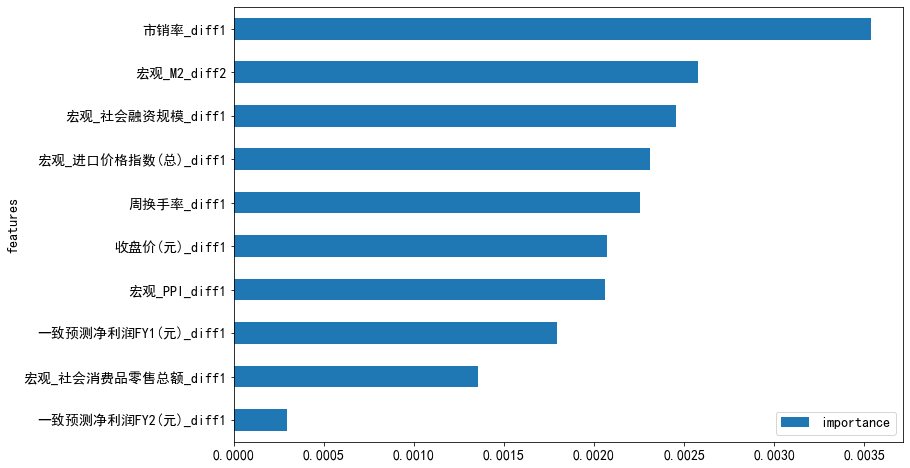

In [61]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
# 为了坐标轴负号正常显示。matplotlib默认不支持中文，设置中文字体后，负号会显示异常。需要手动将坐标轴负号设为False才能正常显示负号。
matplotlib.rcParams['axes.unicode_minus'] = False

hkws_top10 = c.head(10)
print(hkws_top10)
imp = pd.DataFrame(np.array(hkws_top10['importance']), index=hkws_top10['features'], columns=['importance'])
imp.plot(kind='barh', figsize=(12, 8))
#hkws_top10.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [62]:
# rf_pred = pd.DataFrame(rf_pred,columns = ['601668_rf'])
# rf_pred.to_excel('D:\海康威视1.xlsx', index = False)

## 5. Model comparison

In [63]:
# Tuned params and before and after error metrics
c = {'XGBOOST_validation': [ xgb_rmse_aft_tuning, xgb_mae_aft_tuning],
     'Random Forest_validation': [rf_rmse_aft_tuning,rf_mae_aft_tuning],
     'XGBOOST_test': [ xgb_test_rmse_aft_tuning,  xgb_test_mae_aft_tuning],
     'Random Forest_test': [rf_test_rmse_aft_tuning, rf_test_mae_aft_tuning],}
comparison = pd.DataFrame(c)
comparison.index = ['RMSE','MAE']
comparison = comparison.round(3)
comparison

,XGBOOST_validation,Random Forest_validation,XGBOOST_test,Random Forest_test
RMSE,0.013,0.013,0.022,0.022
MAE,0.009,0.009,0.017,0.017
